# Проект для «Викишоп» c BERT

Проект для «Викишоп»¶

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек

In [72]:
#pip install gdown

In [73]:
import time
import datetime

from tqdm import notebook
import gdown


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import uniform
from scipy.stats import loguniform


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

import transformers as ppb
import torch

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

### Определение констант

In [74]:
SEED = 914211
MAX_LEN = 512

### Создание класса

In [75]:
class loguniform_int:


    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [76]:
class text_sentiment_ml():



    def __init__(self, df):
        self.data = df
        self.all_model = {}
    
    @classmethod
    def instance_from_link(cls, link):
        return text_sentiment_ml(pd.read_csv(link,index_col=0))
    
    ### BERT
    def BERT(self):
        model = ppb.AutoModel.from_pretrained('unitary/toxic-bert')
        tokenizer = ppb.AutoTokenizer.from_pretrained('unitary/toxic-bert')

        tokens = (self.data['text'].apply(lambda row: tokenizer.encode(row, add_special_tokens=True,truncation=True)))

        padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in tokens.values])
        attention_mask = np.where(padded != 0, 1, 0)

        batch_size = 2
        embeddings = [] 
        for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda() 
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
                
                with torch.no_grad():
                    model.cuda()
                    batch_embeddings = model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) 
                del batch
                del attention_mask_batch
                del batch_embeddings
                
        self.features = np.concatenate(embeddings)
    
    def get_BERT_features_from_link(self):
        id = '1g4pl4v291c8lWBaRPVa_63lvIkVdfpBK'
        url = url = f'https://drive.google.com/uc?id={id}'
        self.features_BERT = pd.read_csv(gdown.download(url, quiet=False))
        self.features_BERT = self.features_BERT.iloc[:,1:]

    def cut_BERT_features(self, per_size=.1):
         size = round(per_size * self.data.shape[0])
         self.features_BERT_cuted = self.features_BERT.sample(size, random_state=SEED)
         self.target_BERT_cuted = self.data.toxic.loc[self.features_BERT_cuted.index]

    def train_test_split_BERT(self,test_size=.5):
         self.features_train_BERT,self.features_test_BERT,self.target_train_BERT,self.target_test_BERT = train_test_split(self.features_BERT_cuted,
                                                                                                                          self.target_BERT_cuted,
                                                                                                                          test_size=test_size,
                                                                                                                          stratify=self.target_BERT_cuted,
                                                                                                                          random_state=SEED)

    def DecisionTreeClassifier_BERT(self):
        start_time = time.time()
        model = DecisionTreeClassifier(random_state=SEED)
        

        param_distributions = {
            "max_depth": loguniform_int(3, 15),
        }
        
        self.DecisionTreeClassifier_BERT_result = RandomizedSearchCV(
                    model,
                    param_distributions=param_distributions,
                    n_iter=5,
                    verbose=3,
                    scoring='f1',
                    random_state=SEED,
        )

        self.DecisionTreeClassifier_BERT_result.fit(self.features_train_BERT, self.target_train_BERT)

        self.all_model['DecisionTreeClassifier_BERT'] = {'time' : time.time() - start_time}
        self.all_model['DecisionTreeClassifier_BERT']['score'] = self.DecisionTreeClassifier_BERT_result.best_score_


    def RandomForestClassifier_BERT(self):
        start_time = time.time()
        model = RandomForestClassifier(random_state=SEED)
        

        param_distributions = {
            "max_depth": loguniform_int(3, 15),
            'n_estimators' : loguniform_int(10, 50),
        }
        
        self.RandomForestClassifier_BERT_result = RandomizedSearchCV(
                    model,
                    param_distributions=param_distributions,
                    n_iter=5,
                    verbose=3,
                    scoring='f1',
                    return_train_score=True,
                    random_state=SEED,
        )

        self.RandomForestClassifier_BERT_result.fit(self.features_train_BERT, self.target_train_BERT)

        self.all_model['RandomForestClassifier_BERT'] = {'time' : time.time() - start_time}
        self.all_model['RandomForestClassifier_BERT']['score'] = self.RandomForestClassifier_BERT_result.best_score_

    def LGBMClassifier_BERT(self):
        start_time = time.time()
        model = LGBMClassifier(random_state=SEED)
        

        param_distributions = {
            "max_depth": loguniform_int(3, 15),
            'n_estimators' : loguniform_int(10, 100),
        }
        
        self.LGBMClassifier_BERT_result = RandomizedSearchCV(
                    model,
                    param_distributions=param_distributions,
                    n_iter=5,
                    verbose=3,
                    scoring='f1',
                    random_state=SEED,
        )

        self.LGBMClassifier_BERT_result.fit(self.features_train_BERT, self.target_train_BERT)

        self.all_model['LGBMClassifier_BERT'] = {'time' : time.time() - start_time}
        self.all_model['LGBMClassifier_BERT']['score'] = self.LGBMClassifier_BERT_result.best_score_


    def HistGradientBoostingClassifier_BERT(self):

        start_time = time.time()

        model = HistGradientBoostingClassifier(random_state=SEED)
        param_distributions = {
            "l2_regularization": loguniform(1e-6, 1e3),
            "learning_rate": loguniform(0.001, 10),
            "max_leaf_nodes": loguniform_int(2, 256),
            "min_samples_leaf": loguniform_int(1, 100),
            "max_bins": loguniform_int(2, 255),
        }

        self.HistGradientBoostingClassifier_BERT_result = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=5,
            verbose=3,
            scoring='f1',
            random_state=SEED,
        )
        self.HistGradientBoostingClassifier_BERT_result.fit(self.features_train_BERT, self.target_train_BERT)
        
        self.all_model['HistGradientBoostingClassifier_BERT'] = {'time' : time.time() - start_time}
        self.all_model['HistGradientBoostingClassifier_BERT']['score'] = self.LGBMClassifier_BERT_result.best_score_

### Создание экземпляра класса

In [80]:
try:
    comments = text_sentiment_ml.instance_from_link('/Users/ad/Desktop/hello_ds/Practicum/bert_/comments.csv')
except:
    comments = text_sentiment_ml.instance_from_link('https://code.s3.yandex.net//datasets/toxic_comments.csv')

### Общая информация о датасете

In [81]:
comments.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков в данных не обнаружено. Значение индекса не соответствует количеству данных. Количество строк - `159292`, в то время, как индекс содержит значения от `0` до `159450`. Таким образом индекс отличается от действительного количества строк на `158`. Сбросим индекс:

In [82]:
comments.data.reset_index(drop=True, inplace=True)
comments.data.index

RangeIndex(start=0, stop=159292, step=1)

Теперь индекс соответствует количеству данных. Посмотрим на баланс классов:

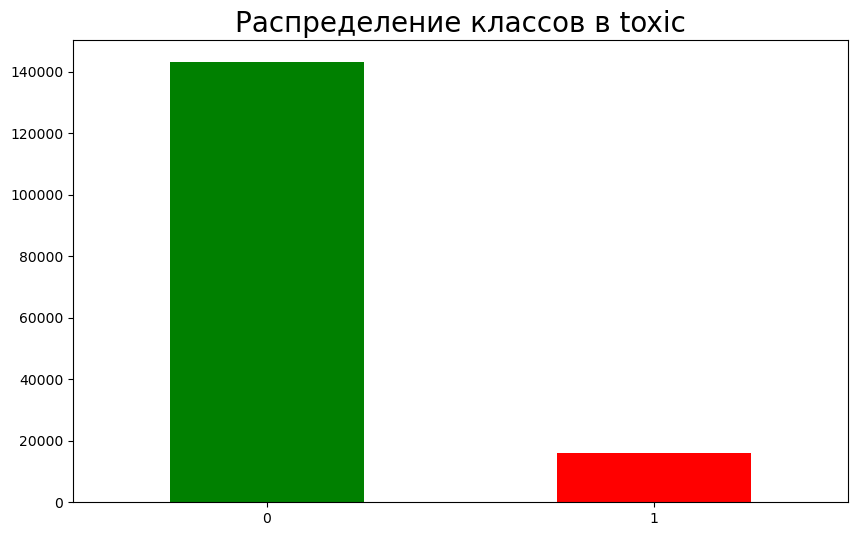

In [83]:
cr = ['g','r']
ax = comments.data['toxic'].value_counts().plot(kind='bar', figsize=(10, 6), color=cr)
plt.title('Распределение классов в toxic', fontsize=20)
plt.xticks(rotation=0)
plt.show()

Наблюдается дисбаланс классов. Нетоксичных комментариев в `8.84` раз больше (`~90%` против `~10%`), чем токсичных.

Обучим модели с использованием BERT.

## Обучение

### Подготовка данных

Скачаем заранее преобразованные эмбенги из csv-файла:

In [84]:
comments.get_BERT_features_from_link()

Downloading...
From (uriginal): https://drive.google.com/uc?id=1g4pl4v291c8lWBaRPVa_63lvIkVdfpBK
From (redirected): https://drive.google.com/uc?id=1g4pl4v291c8lWBaRPVa_63lvIkVdfpBK&confirm=t&uuid=c8822034-6cfa-4638-ad01-c017c2d82274
To: /Users/aleksandrdikov/Desktop/hello_ds/Practicum/bert_/features.csv
100%|██████████| 1.35G/1.35G [00:31<00:00, 43.4MB/s]


Размер датасета слишком велик для обучения. Выберем `30%` случайных значений:

In [85]:
comments.cut_BERT_features(per_size=.2)

In [86]:
print('Выборка имеет размер в {} строк и {} колонок'.format(
    comments.features_BERT_cuted.shape[0],
    comments.features_BERT_cuted.shape[1]
))

Выборка имеет размер в 31858 строк и 768 колонок


### Получение обучающей и тренировочной выборки

В связи с тем, что мы взяли лишь треть выборки, разделим выборку на обучающую и тестовую, как `1` к `1`. Для обучения будем использовать `cross-validation` для улучшения результата:

In [87]:
comments.train_test_split_BERT(test_size=.2)

### Обучение

In [88]:
comments.LGBMClassifier_BERT()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......max_depth=5, n_estimators=10;, score=0.935 total time=   3.9s
[CV 2/5] END ......max_depth=5, n_estimators=10;, score=0.939 total time=   2.9s
[CV 3/5] END ......max_depth=5, n_estimators=10;, score=0.932 total time=   2.8s
[CV 4/5] END ......max_depth=5, n_estimators=10;, score=0.924 total time=   3.2s
[CV 5/5] END ......max_depth=5, n_estimators=10;, score=0.924 total time=   3.0s
[CV 1/5] END ......max_depth=5, n_estimators=10;, score=0.935 total time=   2.9s
[CV 2/5] END ......max_depth=5, n_estimators=10;, score=0.939 total time=   2.6s
[CV 3/5] END ......max_depth=5, n_estimators=10;, score=0.932 total time=   2.5s
[CV 4/5] END ......max_depth=5, n_estimators=10;, score=0.924 total time=   3.7s
[CV 5/5] END ......max_depth=5, n_estimators=10;, score=0.924 total time=   4.5s
[CV 1/5] END .....max_depth=10, n_estimators=23;, score=0.951 total time=   8.0s
[CV 2/5] END .....max_depth=10, n_estimators=23;,

In [89]:
comments.RandomForestClassifier_BERT()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=5, n_estimators=10;, score=(train=0.962, test=0.942) total time=   2.5s
[CV 2/5] END max_depth=5, n_estimators=10;, score=(train=0.965, test=0.952) total time=   2.2s
[CV 3/5] END max_depth=5, n_estimators=10;, score=(train=0.961, test=0.950) total time=   2.3s
[CV 4/5] END max_depth=5, n_estimators=10;, score=(train=0.968, test=0.938) total time=   2.2s
[CV 5/5] END max_depth=5, n_estimators=10;, score=(train=0.965, test=0.933) total time=   2.2s
[CV 1/5] END max_depth=5, n_estimators=10;, score=(train=0.962, test=0.942) total time=   2.2s
[CV 2/5] END max_depth=5, n_estimators=10;, score=(train=0.965, test=0.952) total time=   2.3s
[CV 3/5] END max_depth=5, n_estimators=10;, score=(train=0.961, test=0.950) total time=   2.2s
[CV 4/5] END max_depth=5, n_estimators=10;, score=(train=0.968, test=0.938) total time=   2.4s
[CV 5/5] END max_depth=5, n_estimators=10;, score=(train=0.965, test=0.933) total tim

In [90]:
comments.DecisionTreeClassifier_BERT()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......................max_depth=5;, score=0.927 total time=  10.7s
[CV 2/5] END .......................max_depth=5;, score=0.936 total time=  10.1s
[CV 3/5] END .......................max_depth=5;, score=0.929 total time=   8.6s
[CV 4/5] END .......................max_depth=5;, score=0.919 total time=   8.7s
[CV 5/5] END .......................max_depth=5;, score=0.931 total time=   9.8s
[CV 1/5] END .......................max_depth=3;, score=0.932 total time=   6.0s
[CV 2/5] END .......................max_depth=3;, score=0.936 total time=   5.3s
[CV 3/5] END .......................max_depth=3;, score=0.925 total time=   5.2s
[CV 4/5] END .......................max_depth=3;, score=0.924 total time=   5.2s
[CV 5/5] END .......................max_depth=3;, score=0.923 total time=   5.4s
[CV 1/5] END .......................max_depth=5;, score=0.927 total time=   8.9s
[CV 2/5] END .......................max_depth=5;,

In [91]:
comments.HistGradientBoostingClassifier_BERT()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END l2_regularization=0.0013174688755903435, learning_rate=0.0010649280159864612, max_bins=9, max_leaf_nodes=2, min_samples_leaf=34;, score=0.000 total time=   4.3s
[CV 2/5] END l2_regularization=0.0013174688755903435, learning_rate=0.0010649280159864612, max_bins=9, max_leaf_nodes=2, min_samples_leaf=34;, score=0.000 total time=   3.9s
[CV 3/5] END l2_regularization=0.0013174688755903435, learning_rate=0.0010649280159864612, max_bins=9, max_leaf_nodes=2, min_samples_leaf=34;, score=0.000 total time=   4.2s
[CV 4/5] END l2_regularization=0.0013174688755903435, learning_rate=0.0010649280159864612, max_bins=9, max_leaf_nodes=2, min_samples_leaf=34;, score=0.000 total time=   3.9s
[CV 5/5] END l2_regularization=0.0013174688755903435, learning_rate=0.0010649280159864612, max_bins=9, max_leaf_nodes=2, min_samples_leaf=34;, score=0.000 total time=   4.3s
[CV 1/5] END l2_regularization=0.0022429165441035866, learning_rate=0.

## Выводы

Построим таблицу эффективности моделей:

In [92]:
results = {
    'model' : 
        [*comments.all_model.keys()],
    'score' : 
        [round(comments.all_model[value]['score'],3)
         for value in comments.all_model.keys()],
    'time' : 
        [time.strftime("%M:%S", time.gmtime(comments.all_model[value]['time']))
         for value in comments.all_model.keys()],
    }
display(pd.DataFrame(results))

,model,score,time
0,LGBMClassifier_BERT,0.945,01:47
1,RandomForestClassifier_BERT,0.946,03:39
2,DecisionTreeClassifier_BERT,0.928,04:37
3,HistGradientBoostingClassifier_BERT,0.945,03:20


Модели `RandomForestClassifier`, `LGBMClassifier_BERT` и `HistGradientBoostingClassifier` показывают схожий результат. Если важна скорость обучения, то стоит присмотреться к `HistGradientBoostingClassifier_BERT` и `LGBMClassifier_BERT`. Если главная метрика только `f1_score`, то есть выбрать `RandomForestClassifier_BERT`.

In [93]:
predicts = comments.RandomForestClassifier_BERT_result.predict(comments.features_test_BERT)
print('f1_score на тестовой выборке: {:.3}'.format(f1_score(comments.target_test_BERT, predicts)))

f1_score на тестовой выборке: 0.933


`f1_score` модели `RandomForestClassifier_BERT` на тестовой выборке составил `0.933`, что выше требования в `0.75`

## Вывод

а.

Первоначальные данные содержали в себе:
1. `2 колонки` и `159292 строк`;
2. Первая колонка - колонка с признаком `text`, которая содержит в себе твиты. Вторая - целевой признак `Toxic`;
3. Целевой признак представляет собой два класса, которые плохо сбалансированы (`90%` не токсичных комментариев против `10%` токсичных)

б. 

Эмбенги были прообразованы заранее и сохранены в файл. Для обучения модели была взята выборка в `30%` случайных значений от всего датасета. 

В связи с тем, что была взята не вся выборка, принято решение сделать обучающую выборку `1` к `1`, чтобы модель проходила отбор в более "жестких" условиях.

Для обучения моделей использовался `RandomizedSearchCV` с различными параметрами. Для обучения были взяты следующие модели:

1. DecisionTreeClassifier. Результаты составили: `0.928`;
2. RandomForestClassifier. Результаты составили: `0.946`;
3. LGBMClassifier. Результаты составили: `0.945`;
4. HistGradientBoostingClassifier. Результаты составили: `0.945`.

В связи с этим была выбрана модель `RandomForestClassifier_BERT`, которая на тестовой выборке показала результат `f1_score` - `0.933`

